# Import libraries

In [1]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from MDAnalysis.analysis.distances import distance_array

import pandas as pd
import seaborn as sns
import sys
import time
import warnings
warnings.filterwarnings('ignore')

import lifelines # Used for Lifetime analysis #!pip install lifelines

#pd.set_option('display.max_rows', None)    # None means unlimited.


In [16]:

class ContactMatrix:
    """
    Class to calculate the contact matrix between two selections of atoms within a molecular universe.
    Author: Rubi Zarmiento Garcia
    """
    def __init__(self, universe, selection1, selection2, cutoff,group_by1='resnames',group_by2='resnames'):
        """
        Initializes the ContactMatrix class.
        
        Parameters:
        universe (MDAnalysis.Universe): The molecular universe containing the trajectory.
        selection1 (MDAnalysis.AtomGroup): The first selection of atoms.
        selection2 (MDAnalysis.AtomGroup): The second selection of atoms.
        cutoff (float): The cutoff distance for contacts in angstroms.
        """
        self.universe = universe
        self.selection1 = selection1
        self.selection2 = selection2
        self.cutoff = cutoff
        # Get the attributes to group by, if it is a list, then sum the attributes
        try:
            self.attributes1 = selection1.atoms.__getattribute__(group_by1)
        except:
            if len(selection1.atoms) == 1:
                self.attributes1 = selection1.atoms.__getattribute__(group_by1[0])   
            else: 
                if isinstance(group_by1, list):
                    list_attributes1 = []
                    list_attributes2 = []
                    for attribute in group_by1:
                        list_1 = selection1.atoms.__getattribute__(attribute)
                        #list_2 = selection2.atoms.__getattribute__(attribute)
                        #convert to string
                        list_1 = list(map(str, list_1))
                        list_attributes1.append(list_1)
                        #list_2 = list(map(str, list_2))
                        #list_attributes2.append(list_2)
                    #Sum the first element of each list, then the second element of each list, etc.
                    self.attributes1 = ['%s%s' % x for x in zip(*list_attributes1)]
                    #self.attributes2 = ['%s%s' % x for x in zip(*list_attributes2)]
        try:
            self.attributes2 = selection2.atoms.__getattribute__(group_by2)
        except:
            if len(selection2.atoms) == 1:
                self.attributes2 = selection2.atoms.__getattribute__(group_by2[0])
            else:
                if isinstance(group_by2, list):
                    list_attributes2 = []
                    for attribute in group_by2:
                        list_2 = selection2.atoms.__getattribute__(attribute)
                        #convert to string
                        list_2 = list(map(str, list_2))
                        list_attributes2.append(list_2)
                    #Sum the first element of each list, then the second element of each list, etc.
                    self.attributes2 = ['%s%s' % x for x in zip(*list_attributes2)]

        self.contacts_matrix = np.zeros((len(self.attributes1), len(self.attributes2)), dtype=int)
        self.distances = np.empty((selection1.n_atoms, selection2.n_atoms), dtype=float)
        self.indices1 = self.attributes1
        self.indices2 = self.attributes2
        self.n_frames = len(universe.trajectory)
        
    def calculate_contacts(self):
        """
        Calculates the contact matrix over the entire trajectory and groups by indices1 and indices2.
        """
        for frame in self.universe.trajectory:
            print(f"{frame.frame}/{len(self.universe.trajectory)}", end="\r", file=sys.stderr)
            distance_array(self.selection1.atoms.positions, self.selection2.atoms.positions, result=self.distances)
            contacts = (self.distances < self.cutoff) & (self.distances > 0)
            # Initialize dataframe with unique resnames instead of resnames
            df = pd.DataFrame(contacts, index=self.indices1, columns=self.indices2)
            # Group by resid and if one element is true, then the whole resid is true
            df = df.groupby(df.columns, axis=1).any()
            df = df.groupby(df.index, axis=0).any()
            
            self.contacts_matrix += df.values
        #Set column and row names
        self.contacts_matrix = pd.DataFrame(self.contacts_matrix, index=np.unique(self.attributes1), columns=np.unique(self.selection2.attributes2))
        return self.contacts_matrix
    
    def calculate_contact_matrix_per_observation(self, n_frames):
        """
        Save a contact matrix for every n_frames and stop if the largest value of saves_at is reached.
        """
        contact_matrix_list = []
        saves_at = np.arange(n_frames, self.n_frames + 1, n_frames)
        largest_save_point = saves_at[-1]  # Get the largest value from saves_at

        # Initialize contact matrix outside the loop
        contacts_matrix = np.zeros((len(np.unique(self.attributes1)), len(np.unique(self.attributes2))), dtype=int)
        
        for frame in self.universe.trajectory:
            # Stop if the largest save point is reached
            if frame.frame > largest_save_point:
                print(f"Stopping at frame: {frame.frame}")
                break
            
            # Calculate distances and contacts for the current frame
            distance_array(self.selection1.atoms.positions, self.selection2.atoms.positions, result=self.distances)
            contacts = (self.distances < self.cutoff) & (self.distances > 0)
            df = pd.DataFrame(contacts, index=self.indices1, columns=self.indices2)
            df = df.groupby(df.columns, axis=1).any()
            df = df.groupby(df.index, axis=0).any()
            contacts_matrix += df.values
            
            # Check if the current frame is a point at which to save the contact matrix
            if frame.frame in saves_at:
                print(f"Saving matrix at frame: {frame.frame}")
                contact_matrix_df = pd.DataFrame(contacts_matrix, index=np.unique(self.attributes1), columns=np.unique(self.attributes2))
                contact_matrix_list.append(contact_matrix_df)
                
                # Reset contact matrix for the next period
                contacts_matrix = np.zeros((len(np.unique(self.attributes1)), len(np.unique(self.attributes2))), dtype=int)
        print("Number of contact matrices saved: ", len(contact_matrix_list))
        return contact_matrix_list
    
    def calculate_contact_pairs_matrix_per_observation(self, n_frames):
        """
        Save a contact matrix for every n_frames and stop if the largest value of saves_at is reached.
        """
        contact_matrix_list = []
        saves_at = np.arange(n_frames, self.n_frames + 1, n_frames)

        largest_save_point = saves_at[-1]  # Get the largest value from saves_at

        # Initialize contact matrix outside the loop
        contacts_matrix = np.zeros((len(np.unique(self.attributes1)), len(np.unique(self.attributes2))), dtype=int)
        
        #Initialize attribute1_attribute2 x frames matrix e.g. resname1_resname2 x frames
        #contact_pairs_matrix = np.zeros((len(np.unique(self.attributes1))*len(np.unique(self.attributes2)), self.n_frames), dtype=bool)
        contact_pairs_matrix = []
        # Merge attributes1 and attributes2 with the format 'attribute1_attribute2 and the shape is (n_attributes1 * n_attributes2
        names = []
        for attr1 in np.unique(self.attributes1):
            for attr2 in np.unique(self.attributes2):
                names.append(f"{attr1}_{attr2}")

        print("Shape of contact pairs matrix: ", len(names), self.n_frames)
        current_frame = 0
        for frame in self.universe.trajectory:
            # Stop if the largest save point is reached
            if frame.frame > largest_save_point:
                print(f"Stopping at frame: {frame.frame}")
                break
            
            # Calculate distances and contacts for the current frame
            distance_array(self.selection1.atoms.positions, self.selection2.atoms.positions, result=self.distances)
            contacts = (self.distances < self.cutoff) & (self.distances > 0)
            df = pd.DataFrame(contacts, index=self.indices1, columns=self.indices2)
            df = df.groupby(df.columns, axis=1).any()
            df = df.groupby(df.index, axis=0).any()
            
            # Flatten the dataframe to get contact pairs
            contact_pairs = df.values.flatten()
            # Update the contact pairs matrix for the current frame
            contact_pairs_matrix.append(contact_pairs)

            # Check if the current frame is a point at which to save the contact matrix
            if frame.frame in saves_at:
                print(f"Saving matrix at frame: {frame.frame}")
                # array with frames
                frame_indices = np.arange(current_frame, frame.frame+1, 1)
                current_frame = frame.frame

                contact_matrix_df = pd.DataFrame(contact_pairs_matrix, index=frame_indices, columns=names)
                contact_matrix_list.append(contact_matrix_df)
                # Reset contact matrix for the next period
                contact_pairs_matrix = []
        print("Number of contact matrices saved: ", len(contact_matrix_list))
        
        return contact_matrix_list
    
    def print_contact_matrix_list(self, contact_matrix_list):
        """
        Prints the contact matrix list.
        
        Parameters:
        contact_matrix_list (list): The list of contact matrices.
        """
        for i, contact_matrix in enumerate(contact_matrix_list):
            print(f"Contact matrix {i+1}:")
            print(contact_matrix)
            print()

    def avg_std_matrix_list(self, contact_matrix_list):
        """
        Calculates the average and standard deviation of the contact matrix list.
        
        Parameters:
        contact_matrix_list (list): The list of contact matrices.
        """
        avg_matrix = np.mean(contact_matrix_list, axis=0)
        std_matrix = np.std(contact_matrix_list, axis=0)
        #Add column and row names
        avg_matrix = pd.DataFrame(avg_matrix, index=np.unique(self.attributes1), columns=np.unique(self.attributes2))
        std_matrix = pd.DataFrame(std_matrix, index=np.unique(self.attributes1), columns=np.unique(self.attributes2))
        return avg_matrix, std_matrix
    
    def time_matrix_list(self, contact_matrix_list,universe):
        """
        Calculates the average and standard deviation of the contact matrix list.
        
        Parameters:
        contact_matrix_list (list): The list of contact matrices.
        universe (MDAnalysis.Universe): The molecular universe containing the trajectory.
        """
        total_time = universe.trajectory.totaltime
        total_frames = universe.trajectory.n_frames
        time_per_frame = total_time/total_frames
        time_matrix_list = []
        for matrix in contact_matrix_list:
            time_matrix = matrix*time_per_frame
            time_matrix_list.append(time_matrix)
        return time_matrix_list
            
    def distance_vs_time(self):
        """
        Calculates distance vs time between two selections.
        """
        #Distance matrix shape: n_frames x n_atoms1 
        distance_matrix = np.empty((self.n_frames, len(np.unique(self.attributes1))), dtype=float)
        print("Shape of distance matrix: ", distance_matrix.shape)
        #distance_array(self.selection1.atoms.positions, self.selection2.atoms.positions, result=self.distances)
        for frame in self.universe.trajectory:
            print(f"{frame.frame}/{len(self.universe.trajectory)}", end="\r", file=sys.stderr)
            distance_array(self.selection1.atoms.positions, self.selection2.atoms.positions, result=self.distances)
            # Initialize dataframe with unique resnames instead of resnames
            df = pd.DataFrame(self.distances, index=self.indices1, columns=self.indices2)
            # Group by resid and only conserve the minimum distance of selection2
            df = df.groupby(df.index, axis=0).min()
            df = df.groupby(df.columns, axis=1).min()
            #df = df.groupby(df.columns, axis=1).any()
            #df = df.groupby(df.index, axis=0).any()
            #Save in distance matrix
            distance_matrix[frame.frame,:] = df.values.flatten()
        #Convert to dataframe
        distance_matrix = pd.DataFrame(distance_matrix, index=np.arange(1,self.n_frames+1), columns=np.unique(self.attributes1))
        

        return distance_matrix
        
#Function to plot the contact matrix
def plot_contact_matrix(contact_matrix,n_frames,figsize=(5,5),cmap="coolwarm"):
    """
    Plots the contact matrix.

    Parameters:
    contact_matrix (pd.DataFrame): The contact matrix.
    n_frames (int): The number of frames in the trajectory.
    figsize (tuple): The figure size.
    cmap (str): The colormap.
    """
    plt.figure(figsize=figsize)
    #Set the axis to start from lower to higher

    sns.heatmap(contact_matrix, cmap=cmap, vmin=0, vmax=n_frames)
    plt.axes().invert_yaxis()
    plt.show()

def plot_one_subplot_per_column_dataframe(df,ylabel="ylabel",xlabel="xlabel",ymax=None,pallette='tab10',hline=None):
    """
    Plots one lineplot per column of a dataframe in a single figure with subplots.

    Parameters:
    df (pd.DataFrame): The dataframe.
    ylabel (str): The ylabel.
    xlabel (str): The xlabel.
    ymax (float): The maximum value of the y axis.
    """
    n_subplots = df.shape[1]
    subplot_per_row = 3
    subplot_per_column = int(np.ceil(n_subplots/subplot_per_row))
    fig, axes = plt.subplots(subplot_per_column, subplot_per_row, figsize=(15, 5*subplot_per_column))
    for i, column in enumerate(df.columns):
        sns.lineplot(x=df.index, y=column, data=df, ax=axes[i//subplot_per_row, i%subplot_per_row], palette=pallette)
        #Set labels
        axes[i//subplot_per_row, i%subplot_per_row].set_title(column)
        axes[i//subplot_per_row, i%subplot_per_row].set_ylabel(ylabel)
        axes[i//subplot_per_row, i%subplot_per_row].set_xlabel(xlabel)
        #set y limit
        if ymax is not None:
            axes[i//subplot_per_row, i%subplot_per_row].set_ylim(0,ymax)
        if hline is not None:
            axes[i//subplot_per_row, i%subplot_per_row].axhline(y=hline, color="black", linestyle='--')

    plt.tight_layout()
    #Turn off any unused subplots
    for i in range(n_subplots,subplot_per_row*subplot_per_column):
        axes[i//subplot_per_row, i%subplot_per_row].axis('off')

    
    plt.show()


def extract_lifetimes(df):
    """
    Extract lifetimes from a DataFrame where each column contains binary time series data.
    
    Parameters:
    df (pd.DataFrame): DataFrame with shape (labels x time) containing binary data (0s and 1s)
    
    Returns:
    list: List of arrays, where each array contains the lifetimes (consecutive 1s) for each column
    
    Example:
    If a column has data [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1], 
    it returns [3, 2] representing two lifetimes of length 3 and 2.
    """
    lifetimes_per_column = []
    
    for column in df.columns:
        column_data = df[column].values
        lifetimes = []
        current_lifetime = 0
        
        for value in column_data:
            if value == 1:
                current_lifetime += 1
            else:
                if current_lifetime > 0:
                    lifetimes.append(current_lifetime)
                    current_lifetime = 0
        
        # Don't forget the last lifetime if the sequence ends with 1s
        if current_lifetime > 0:
            lifetimes.append(current_lifetime)
        
        lifetimes_per_column.append(np.array(lifetimes))
    
    return lifetimes_per_column

# Alternative more compact version using groupby
def extract_lifetimes_vectorized(df):
    """
    Vectorized version using pandas groupby for better performance.
    """
    lifetimes_per_column = []
    
    for column in df.columns:
        series = df[column]
        # Create groups where consecutive identical values are grouped together
        groups = (series != series.shift()).cumsum()
        
        # Filter for groups where the value is 1 and get their sizes
        lifetimes = series.groupby(groups).size()[series.groupby(groups).first() == 1].values
        lifetimes_per_column.append(lifetimes)
    
    return lifetimes_per_column

# Get pairs of contacts e.g. resid1 resid2 true/false
def get_contact_pairs(contact_matrix_list):
    """
    Extracts contact pairs from a list of contact matrices.
    
    Parameters:
    contact_matrix_list (list): List of contact matrices (DataFrames).
    
    Returns:
    pd.DataFrame: DataFrame with contact pairs and their status (True/False).
    """
    contact_pairs = []
    for matrix in contact_matrix_list:
        for index, row in matrix.iterrows():
            for col in matrix.columns:
                # Do not include contacts with no interaction
                if row[col]:
                    contact_pairs.append((index, col, True))
                else:
                    continue

    
    return pd.DataFrame(contact_pairs, columns=['resid1', 'resid2', 'contact'])

def sort_atomgroup_by_z(atomgroup):
    """
    Sort an atomgroup by z-coordinate of center of geometry for each resid.
    
    Parameters:
    atomgroup (MDAnalysis.AtomGroup): The atomgroup to sort
    
    Returns:
    tuple: (sorted_resids, sorted_z_positions) - Arrays of resids and their z-coordinates sorted by z (highest to lowest)
    """
    # Get unique resids from atomgroup
    unique_resids = np.unique(atomgroup.resids)
    
    # Calculate center of geometry for each resid and sort by z position
    resid_z_pairs = []
    for resid in unique_resids:
        atoms_in_resid = atomgroup.atoms[atomgroup.atoms.resids == resid]
        center_of_geometry = atoms_in_resid.center_of_geometry()
        resid_z_pairs.append((resid, center_of_geometry[2]))
    
    # Sort by z coordinate (highest to lowest)
    resid_z_pairs.sort(key=lambda x: x[1], reverse=True)
    
    # Extract sorted resids and z positions
    sorted_resids = np.array([resid for resid, z in resid_z_pairs])
    sorted_z_positions = np.array([z for resid, z in resid_z_pairs])
    
    return sorted_resids, sorted_z_positions

def get_contact_pairs(contact_matrix_input):
    """
    Extracts contact pairs from either a single contact matrix or a list of contact matrices.
    
    Parameters:
    contact_matrix_input (pd.DataFrame or list): Either a single contact matrix (DataFrame) 
                                               or a list of contact matrices (DataFrames).
    
    Returns:
    pd.DataFrame: DataFrame with contact pairs and their status (True/False).
    """
    contact_pairs = []
    
    # Check if input is a single DataFrame or a list
    if isinstance(contact_matrix_input, pd.DataFrame):
        # Single matrix case
        matrices_to_process = [contact_matrix_input]
    elif isinstance(contact_matrix_input, list):
        # List of matrices case
        matrices_to_process = contact_matrix_input
    else:
        raise TypeError("Input must be either a pandas DataFrame or a list of DataFrames")
    
    # Process each matrix
    for matrix in matrices_to_process:
        for index, row in matrix.iterrows():
            for col in matrix.columns:
                # Only include contacts with interaction
                if row[col]:
                    contact_pairs.append((index, col, True))
    
    return pd.DataFrame(contact_pairs, columns=['resid1', 'resid2', 'contact'])

# Load universe

In [19]:
structure = "/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/binding_poses_test/clust_c045/centers.pdb"
# Updated selections based on what's actually in the PDB file
sel2 = 'id 1:498'  # Protein chains
sel1 = 'not id 1:498 and not resname CLA CLB CHL *HG* PLQ PL9 *GG* *SQ* *PG* LUT VIO XAT NEO NEX W2 HOH BCR'  # All other chains (ligands/molecules)
cutoff = 0.8*10 # 0.8 nm, converted to Angstroms

u = mda.Universe(structure)
sel1 = u.select_atoms(sel1)
sel2 = u.select_atoms(sel2)
n_frames = len(u.trajectory)

#Print the number of frames
print("Number of frames: ", n_frames)
print(f"Total atoms in universe: {u.atoms.n_atoms}")
print(f"Available chains: {np.unique([atom.chainID for atom in u.atoms])}")

Number of frames:  219
Total atoms in universe: 1704
Available chains: ['' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N']


In [105]:
contact_matrix_obj = ContactMatrix(u, sel1, sel2, 8, group_by1="resids", group_by2="resids")
contact_matrix_list = contact_matrix_obj.calculate_contact_matrix_per_observation(1)
time_matrix_list = contact_matrix_obj.time_matrix_list(contact_matrix_list,u)

Saving matrix at frame: 1
Saving matrix at frame: 2
Saving matrix at frame: 3
Saving matrix at frame: 4
Saving matrix at frame: 5
Saving matrix at frame: 6
Saving matrix at frame: 7
Saving matrix at frame: 8
Saving matrix at frame: 9
Saving matrix at frame: 10
Saving matrix at frame: 11
Saving matrix at frame: 12
Saving matrix at frame: 13
Saving matrix at frame: 14
Saving matrix at frame: 15
Saving matrix at frame: 16
Saving matrix at frame: 17
Saving matrix at frame: 18
Saving matrix at frame: 19
Saving matrix at frame: 20
Saving matrix at frame: 21
Saving matrix at frame: 22
Saving matrix at frame: 23
Saving matrix at frame: 24
Saving matrix at frame: 25
Saving matrix at frame: 26
Saving matrix at frame: 27
Saving matrix at frame: 28
Saving matrix at frame: 29
Saving matrix at frame: 30
Saving matrix at frame: 31
Saving matrix at frame: 32
Saving matrix at frame: 33
Saving matrix at frame: 34
Saving matrix at frame: 35
Saving matrix at frame: 36
Saving matrix at frame: 37
Saving mat

In [107]:
avg_matrix, std_matrix = contact_matrix_obj.avg_std_matrix_list(contact_matrix_list)
contact_matrix_obj.print_contact_matrix_list(contact_matrix_list)
#Save avg_matrix and std_matrix to csv
avg_matrix.to_csv('/martini/rubiz/Github/PsbS_Binding_Site/4_pairs/analysis/chain_4/test.csv')


Contact matrix 1:
     1    2    3    4    5    6    7    8    9    10   ...  201  202  203  \
1      2    2    2    1    0    1    0    0    0    0  ...    0    0    0   
2      0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
3      0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
4      0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
5      0    0    1    2    2    2    2    1    0    0  ...    0    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
420    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
421    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
422    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
423    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
424    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   

     204  205  206  207  208  209  210  
1      0    0   

# Filter atomogroup by cut-off

In [294]:
contact_pairs_df = get_contact_pairs(contact_matrix_list[0])
print("Contact pairs DataFrame:")
display(contact_pairs_df)
print(contact_pairs_df.shape)

Contact pairs DataFrame:


,resid1,resid2,contact
0,1,1,True
1,1,2,True
2,1,3,True
3,1,4,True
4,1,6,True
5,1,11,True
6,1,15,True
7,5,3,True
8,5,4,True
9,5,5,True


(34, 3)


# Sort atomgroups by z

In [116]:
# Use the function with sel1
sel1_sorted_z, z1_cg = sort_atomgroup_by_z(sel1) # Sort sel1 by z-coordinate and return z value of the center of geometry 
sel2_sorted_z, z2_cg = sort_atomgroup_by_z(sel2) # Sort sel2 by z-coordinate and return z value of the center of geometry


In [117]:
# Create a mapping dictionary from resid to z-coordinate
resid_to_z = {}
for resid in contact_pairs_df['resid1'].unique():
    # Find the index where this resid appears in sel1_sorted_z
    index = np.where(sel1_sorted_z == resid)[0][0] # Index in sorted
    z = z1_cg[index] # Get the z-coordinate of the center of geometry
    resid_to_z[resid] = z

# Map z-coordinates to each row based on resid1
contact_pairs_df['z1'] = contact_pairs_df['resid1'].map(resid_to_z)

# Create a mapping dictionary from resid to z-coordinate
resid_to_z = {}
for resid in contact_pairs_df['resid2'].unique():
    # Find the index where this resid appears in sel1_sorted_z
    index = np.where(sel1_sorted_z == resid)[0][0] # Index in sorted
    z = z1_cg[index] # Get the z-coordinate of the center of geometry
    resid_to_z[resid] = z

# Map z-coordinates to each row based on resid1
contact_pairs_df['z2'] = contact_pairs_df['resid2'].map(resid_to_z)



In [118]:
display(contact_pairs_df)

,resid1,resid2,contact,z1,z2
0,1,1,True,-0.882333,-0.882333
1,1,2,True,-0.882333,10.495000
2,1,3,True,-0.882333,3.466000
3,1,4,True,-0.882333,6.793000
4,1,6,True,-0.882333,0.617000
5,1,11,True,-0.882333,-4.707000
6,1,15,True,-0.882333,-6.264000
7,5,3,True,1.262250,3.466000
8,5,4,True,1.262250,6.793000
9,5,5,True,1.262250,1.262250


In [119]:
# Sort resid1 by z-coordinate
sorted_resid1 = contact_pairs_df.sort_values(by="z1", ascending=False)

In [120]:
print(sorted_resid1)

    resid1  resid2  contact         z1         z2
9        5       5     True   1.262250   1.262250
8        5       4     True   1.262250   6.793000
11       5       7     True   1.262250  -2.907000
12       5       8     True   1.262250  -4.418000
7        5       3     True   1.262250   3.466000
10       5       6     True   1.262250   0.617000
1        1       2     True  -0.882333  10.495000
0        1       1     True  -0.882333  -0.882333
5        1      11     True  -0.882333  -4.707000
2        1       3     True  -0.882333   3.466000
6        1      15     True  -0.882333  -6.264000
3        1       4     True  -0.882333   6.793000
4        1       6     True  -0.882333   0.617000
33     128       7     True  -4.633000  -2.907000
31     128       5     True  -4.633000   1.262250
32     128       6     True  -4.633000   0.617000
14     115       8     True  -4.650500  -4.418000
13     115       5     True  -4.650500   1.262250
15     120       8     True  -8.042000  -4.418000


In [216]:
unique_resid1 = contact_pairs_df['resid1'].unique()
unique_resid2 = contact_pairs_df['resid2'].unique()

z1 = []
resid_resname1 = []
for resid in unique_resid1:
    index = np.where(sel1_sorted_z == resid)[0][0] # Index in sorted
    z = z1_cg[index] # Get the z-coordinate of the center of geometry
    z1.append(z)
    resname = sel1.select_atoms(f'resid {resid}').resnames[0]  # Get the resname for the resid
    resid_resname = f"{resid}{resname}"
    resid_resname1.append(resid_resname)
z2 = []
resid_resname2 = []

for resid in unique_resid2:
    index = np.where(sel2_sorted_z == resid)[0][0] # Index in sorted
    z = z2_cg[index] # Get the z-coordinate of the center of geometry
    z2.append(z)
    resname = sel2.select_atoms(f'resid {resid}').resnames[0]  # Get the resname for the resid
    resid_resname = f"{resid}{resname}"
    resid_resname2.append(resid_resname)


print("Unique resid1:", unique_resid1)
print("Unique resid2:", unique_resid2)
print("Z-coordinates for resid1:", z1)
print("Z-coordinates for resid2:", z2)
print("Resid_resname1:", resid_resname1)
print("Resid_resname2:", resid_resname2)

Unique resid1: [  1   5 115 120 122 124 125 126 127 128]
Unique resid2: [ 1  2  3  4  6 11 15  5  7  8]
Z-coordinates for resid1: [-0.8823331197102865, 1.2622499465942383, -4.650500059127808, -8.041999816894531, -9.886333306630453, -12.16100025177002, -14.605000019073486, -10.786999702453613, -9.460000038146973, -4.6330000559488935]
Z-coordinates for resid2: [-16.411499500274658, -16.34249973297119, -12.789000034332275, -10.502500057220459, -9.619500160217285, -13.06850004196167, -18.158999919891357, -8.299000024795532, -10.81583340962728, -13.087500095367432]
Resid_resname1: ['1LEU', '5LYS', '115ILE', '120ASP', '122ARG', '124ALA', '125LEU', '126GLY', '127LEU', '128LYS']
Resid_resname2: ['1ALA', '2ALA', '3SER', '4ALA', '6ILE', '11PRO', '15PHE', '5PRO', '7TRP', '8SER']


In [217]:
# Merge z1 and resid_resname1 into a DataFrame
z1_df = pd.DataFrame({'resid_resname1': resid_resname1, 'z1': z1})
z2_df = pd.DataFrame({'resid_resname2': resid_resname2, 'z2': z2})

#Sort the DataFrame by z1 and z2
z1_df = z1_df.sort_values(by='z1', ascending=True)
z2_df = z2_df.sort_values(by='z2', ascending=True)

In [243]:


y1 = [1, 4, 7] * (len(unique_resid1) // 3) + [1, 4, 7][:len(unique_resid1) % 3]
y2 = [15, 18, 21] * (len(unique_resid2) // 3) + [15, 18, 21][:len(unique_resid2) % 3]
print("Y-coordinates for resid1:", y1)
print("Y-coordinates for resid2:", y2)




Y-coordinates for resid1: [1, 4, 7, 1, 4, 7, 1, 4, 7, 1]
Y-coordinates for resid2: [15, 18, 21, 15, 18, 21, 15, 18, 21, 15]


In [219]:
z1 = np.array(z1_df['z1'])
z2 = np.array(z2_df['z2'])
labels1 = np.array(z1_df['resid_resname1'])
labels2 = np.array(z2_df['resid_resname2'])
print("Z-coordinates1:", z1)
print("Z-coordinates2:", z2)
print("Labels1:", labels1)
print("Labels2:", labels2)

Z-coordinates1: [-14.60500002 -12.16100025 -10.7869997   -9.88633331  -9.46000004
  -8.04199982  -4.65050006  -4.63300006  -0.88233312   1.26224995]
Z-coordinates2: [-18.15899992 -16.4114995  -16.34249973 -13.0875001  -13.06850004
 -12.78900003 -10.81583341 -10.50250006  -9.61950016  -8.29900002]
Labels1: ['125LEU' '124ALA' '126GLY' '122ARG' '127LEU' '120ASP' '115ILE' '128LYS'
 '1LEU' '5LYS']
Labels2: ['15PHE' '1ALA' '2ALA' '8SER' '11PRO' '3SER' '7TRP' '4ALA' '6ILE' '5PRO']


In [220]:
cmap = mpl.colormaps['Set3']  # Use a colormap with 10 distinct colors
colors1 = [cmap(i) for i in range(4)]       # First 4 colors: 0, 1, 2, 3
colors2 = [cmap(i) for i in range(4, 8)]    # Next 4 colors: 4, 5, 6, 7

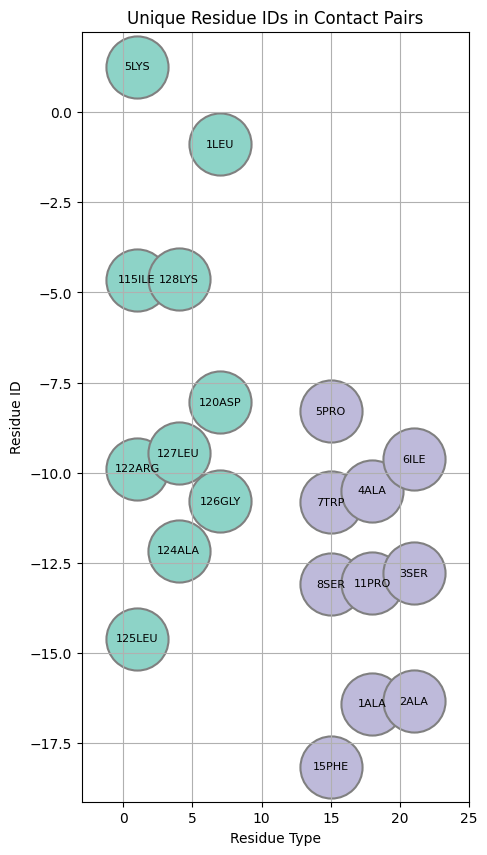

In [221]:
# Plot the unique resid1 and resid2 as a scatter plot
x_limits = (-3, 25)
plt.figure(figsize=(5, 10))
#plt.scatter(y1,z1, label='Resid1', color='grey', alpha=1, s=1100)
#plt.scatter(y2,z2, label='Resid2', color='grey', alpha=1, s=1100)
plt.scatter(y1,z1, label='Resid1', color=colors1[0], alpha=1, s=2000,edgecolor='grey', linewidth=1.5)
plt.scatter(y2,z2, label='Resid2', color=colors1[2], alpha=1, s=2000,edgecolor='grey', linewidth=1.5)
#add labels resid_resname1 and resid_resname2 to the points
for i, txt in enumerate(labels1):
    plt.annotate(txt, (y1[i], z1[i]), fontsize=8, ha='center', va='center', color='black')
for i, txt in enumerate(labels2):
    plt.annotate(txt, (y2[i], z2[i]), fontsize=8, ha='center', va='center', color='black')
plt.xlabel('Residue Type')
plt.ylabel('Residue ID')
plt.title('Unique Residue IDs in Contact Pairs')
# Set limits for x-axis
plt.xlim(x_limits)

plt.grid()
plt.show()

In [247]:
df_resid1_y1 = pd.DataFrame({'resid_resname1': labels1, 'y1': y1})
df_resid2_y2 = pd.DataFrame({'resid_resname2': labels2, 'y2': y2})

contact_pairs_z1_sorted = contact_pairs_df.sort_values(by='z1', ascending=True)
contact_pairs_z2_sorted = contact_pairs_df.sort_values(by='z2', ascending=True)


# Add y1 and y2 to the contact_pairs_df
for i in range(unique_resid1.shape[0]):
    contact_pairs_df.loc[contact_pairs_z1_sorted['resid1'] == unique_resid1[i], 'y1'] = y1[i]
for i in range(unique_resid2.shape[0]):
    contact_pairs_df.loc[contact_pairs_z2_sorted['resid2'] == unique_resid2[i], 'y2'] = y2[i]

# Add label column to both 
# Get resnames for each resid in contact_pairs_df
# Add resname columns to the DataFrame from the universe
# Get resnames for each resid in contact_pairs_df
contact_pairs_df['resname1'] = [sel1.select_atoms(f'resid {resid}').resnames[0] for resid in contact_pairs_df['resid1']]
contact_pairs_df['resname2'] = [sel2.select_atoms(f'resid {resid}').resnames[0] for resid in contact_pairs_df['resid2']]

# Sort the dataframes by z coordinates
contact_pairs_z1_sorted = contact_pairs_df.sort_values(by='z1', ascending=True)
contact_pairs_z2_sorted = contact_pairs_df.sort_values(by='z2', ascending=True)

# Create resid_resname labels
contact_pairs_z1_sorted['resid_resname1'] = contact_pairs_z1_sorted['resid1'].astype(str) + contact_pairs_z1_sorted['resname1']
contact_pairs_z1_sorted['resid_resname2'] = contact_pairs_z1_sorted['resid2'].astype(str) + contact_pairs_z1_sorted['resname2']
contact_pairs_z2_sorted['resid_resname1'] = contact_pairs_z2_sorted['resid1'].astype(str) + contact_pairs_z2_sorted['resname1']
contact_pairs_z2_sorted['resid_resname2'] = contact_pairs_z2_sorted['resid2'].astype(str) + contact_pairs_z2_sorted['resname2']

In [251]:
display(contact_pairs_z1_sorted)

,resid1,resid2,contact,z1,z2,y1,y2,resname1,resname2,resid_resname1,resid_resname2
25,125,4,True,-14.605000,6.793000,1.0,15.0,LEU,ALA,125LEU,4ALA
26,125,5,True,-14.605000,1.262250,1.0,18.0,LEU,PRO,125LEU,5PRO
22,124,5,True,-12.161000,1.262250,7.0,18.0,ALA,PRO,124ALA,5PRO
20,124,1,True,-12.161000,-0.882333,7.0,15.0,ALA,ALA,124ALA,1ALA
24,124,8,True,-12.161000,-4.418000,7.0,15.0,ALA,SER,124ALA,8SER
23,124,6,True,-12.161000,0.617000,7.0,18.0,ALA,ILE,124ALA,6ILE
21,124,4,True,-12.161000,6.793000,7.0,15.0,ALA,ALA,124ALA,4ALA
27,126,4,True,-10.787000,6.793000,4.0,15.0,GLY,ALA,126GLY,4ALA
28,126,5,True,-10.787000,1.262250,4.0,18.0,GLY,PRO,126GLY,5PRO
19,122,8,True,-9.886333,-4.418000,4.0,15.0,ARG,SER,122ARG,8SER


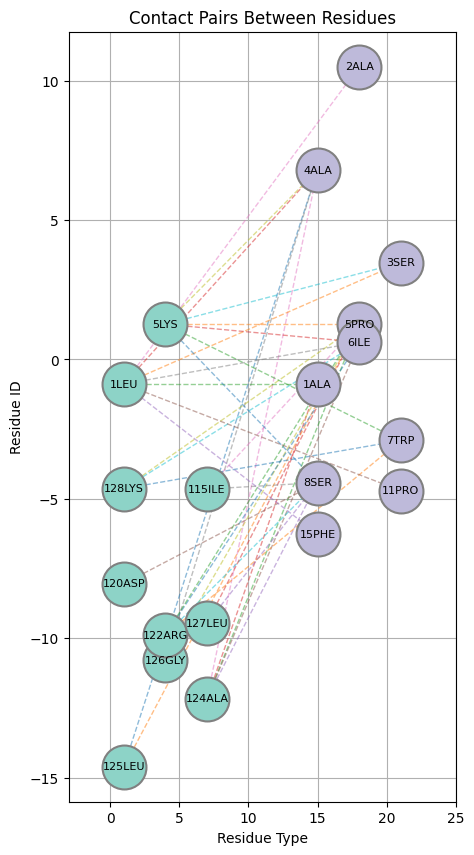

In [306]:
# Plot the unique resid1 and resid2 as a scatter plot
x_limits = (-3, 25)
plt.figure(figsize=(5, 10))

cmap2 = mpl.colormaps['tab10']
n_colors = len(contact_pairs_z1_sorted['resid_resname1'].unique())
colors1 = [cmap2(i) for i in range(n_colors)]  # Generate

# Plot lines FIRST (so they appear behind the markers)
for i in range(len(contact_pairs_z1_sorted)):
    y1_coord = contact_pairs_z1_sorted['y1'].iloc[i]
    y2_coord = contact_pairs_z1_sorted['y2'].iloc[i]
    z1_coord = contact_pairs_z1_sorted['z1'].iloc[i]
    z2_coord = contact_pairs_z1_sorted['z2'].iloc[i]
    plt.plot([y1_coord, y2_coord], [z1_coord, z2_coord], color=colors1[i % len(colors1)], alpha=.5, linewidth=1, linestyle='--')

# Plot scatter points SECOND with explicit z-order
cmap2 = mpl.colormaps['Set3']
colors2 = [cmap2(0), cmap2(2)]

# Get UNIQUE positions for scatter plot to avoid duplicates
unique_pos_1 = contact_pairs_z1_sorted[['y1', 'z1', 'resid_resname1']].drop_duplicates()
unique_pos_2 = contact_pairs_z1_sorted[['y2', 'z2', 'resid_resname2']].drop_duplicates()

# Plot scatter with explicit zorder to ensure they're on top
plt.scatter(unique_pos_1['y1'], unique_pos_1['z1'], 
           label='Resid1', color=colors2[0], alpha=1, s=1000, 
           edgecolor='grey', linewidth=1.5, zorder=5)
plt.scatter(unique_pos_2['y2'], unique_pos_2['z2'], 
           label='Resid2', color=colors2[1], alpha=1, s=1000, 
           edgecolor='grey', linewidth=1.5, zorder=5)

# Add labels with even higher zorder
for _, row in unique_pos_1.iterrows():
    plt.annotate(row['resid_resname1'], (row['y1'], row['z1']), 
                fontsize=8, ha='center', va='center', color='black', zorder=6)

for _, row in unique_pos_2.iterrows():
    plt.annotate(row['resid_resname2'], (row['y2'], row['z2']), 
                fontsize=8, ha='center', va='center', color='black', zorder=6)

plt.xlabel('Residue Type')
plt.ylabel('Residue ID')
plt.title('Contact Pairs Between Residues')
plt.xlim(x_limits)
plt.grid(zorder=0)  # Put grid behind everything
plt.show()

# Add connection between atomsgroups